# Installations & Imports

In [ ]:
# pandas for manipulating our data
# matplotlib for visualizing our data
# tensorflow for our tokenization and embedding
# sklearn for our models
!pip install pandas matplotlib tensorflow
!pip install -U scikit-learn
from IPython.display import clear_output

# all we've done is installed and imported modules so we don't care about the output
clear_output()

In [80]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_union
from sklearn.model_selection import train_test_split, KFold

import keras
from keras.layers import Embedding, Dense, TextVectorization, GlobalAveragePooling1D, LSTM, Dropout, Bidirectional
from keras.models import Sequential

import tensorflow as tf

# Preprocessing

In [ ]:
# Mount Drive

In [81]:
# Base path for project
base_path = "/content/drive/MyDrive/Winter Term [2024]/Machine Learning (CS320)/Final Project"

# Fetch & read csv files from drive
file_path = base_path+"/Datasets/jigsaw-toxic-comment-classification-challenge.csv"
df = pd.read_csv(file_path)

# Display what the header of our new dataframe looks like # df.shape == (159571, 8)
df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [82]:
# features represents our input of strings, which in this case are comments
# labels represents an m by n matrix of our categorization label booleans from columns toxic -> identity_hate (i.e. all rows for all columns after index 2)
# toxic_labels represents the booleans for our toxic column (i.e. all rows for column 0)
features = df["comment_text"].values
toxic_labels = df["toxic"].values

### Encode Binary -- Used Later

In [83]:
def encode_binary(output):
  return np.array([0 if i < 0.5 else 1 for i in output])

In [84]:
def preprocess_data(max_feat, n_grams):
  # Split our data into training & testing data
  X_train, X_test, y_train, y_test = train_test_split(features, toxic_labels, test_size=0.25, random_state=42)

  # We will now vectorize i.e tokenize our each word in our comment features, which are in a 1d array of shape (159571,).
  count_vectorizer = CountVectorizer(max_features=max_feat, analyzer="word", ngram_range=n_grams, stop_words="english")

  # an array with one column for each unique word in the original input array and one row for each feature (comment/phrase)
  X_train = count_vectorizer.fit_transform(X_train)
  X_test = count_vectorizer.transform(X_test)

  # convert bag_of_words sparse array, into a dense array of bag_of_words
  X_train = X_train.toarray()
  X_test = X_test.toarray()

  return X_train, X_test, y_train, y_test

# Logistic Regression

In [ ]:
# Preprocess our data
X_train, X_test, y_train, y_test = preprocess_data(4000, (1,3))

In [ ]:
# Build & fit our model
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Serialize my LR_model
with open(base_path+"/Serializations/LR_model", "wb") as fp: pickle.dump(LR_model, fp)

In [ ]:
# Read (load) in my LR_model
LR_model = pickle.load(open(base_path+"/Serializations/LR_model", "rb"))

In [ ]:
LR_predictions = LR_model.predict(X_test)

LR_accuracy = accuracy_score(y_test, LR_predictions)
LR_precision = precision_score(y_test, LR_predictions)
LR_recall = recall_score(y_test, LR_predictions)

print("Accuracy:", LR_accuracy)
print("Precision:", LR_precision)
print("Recall:", LR_recall)

Accuracy: 0.9517208532825308
Precision: 0.8443310244258112
Recall: 0.6070773263433814


Text(0.5, 1.0, 'LR Confusion Matrix')

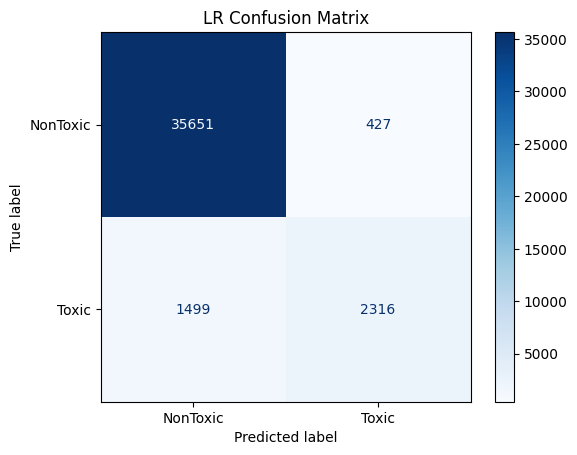

In [ ]:
# Build our confusion matrix
LR_CM = confusion_matrix(y_true=y_test, y_pred=LR_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=LR_CM, display_labels=["NonToxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("LR Confusion Matrix")

# Naive Bayes

In [85]:
# Preprocess our data
X_train, X_test, y_train, y_test = preprocess_data(2000, (1,1))

In [ ]:
# Build & fit our model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Serialize (pickle) my NB_model
with open(base_path+"/Serializations/NB_model", "wb") as fp: pickle.dump(NB_model, fp)

In [ ]:
# Read (load) in my LR_model
NB_model = pickle.load(open(base_path+"/Serializations/NB_model", "rb"))

In [ ]:
NB_predictions = NB_model.predict(X_test)

NB_accuracy = accuracy_score(y_test, NB_predictions)
NB_precision = precision_score(y_test, NB_predictions)
NB_recall = recall_score(y_test, NB_predictions)

print("Accuracy:", NB_accuracy)
print("Precision:", NB_precision)
print("Recall:", NB_recall)

Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175


Text(0.5, 1.0, 'NB Confusion Matrix')

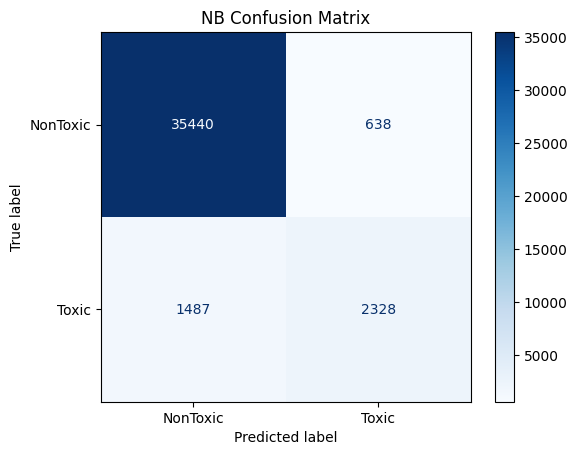

In [ ]:
# Build our confusion matrix
NB_cm = confusion_matrix(y_true=y_test, y_pred=NB_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=NB_cm, display_labels=["NonToxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("NB Confusion Matrix")

# Neural Network

In [ ]:
# Preprocess our data
X_train, X_test, y_train, y_test = preprocess_data(2000, (1,3))

In [ ]:
NN_model = Sequential()
NN_model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
NN_model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
NN_model.add(Dense(100, input_dim=X_train.shape[1], activation="relu"))
NN_model.add(Dense(1, activation="sigmoid"))

NN_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "Precision", "Recall"])
NN_model.summary()

NN_model.fit(x=X_train, y=y_train, epochs=3, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               200100    
                                                                 
 dense_5 (Dense)             (None, 256)               25856     
                                                                 
 dense_6 (Dense)             (None, 100)               25700     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 251757 (983.43 KB)
Trainable params: 251757 (983.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
3740/3740 [==============================] - 17s 4ms/step - loss: 0.1686 - accuracy: 0.9470 - precision: 0.8661 - recall: 0.5296
Epoch 2

In [ ]:
# Serialize (pickle) my NN_model
with open(base_path+"/Serializations/NN_model", "wb") as fp: pickle.dump(NN_model, fp)

1247/1247 [==============================] - 2s 2ms/step


Text(0.5, 1.0, 'NN Confusion Matrix')

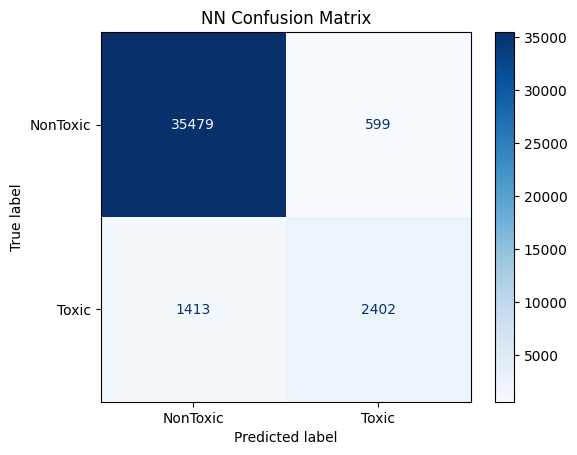

In [ ]:
# Read (load) in my NN_Model
NN_model = pickle.load(open(base_path+"/Serializations/NN_model", "rb"))

NN_pred = encode_binary(NN_model.predict(X_test))
NN_CM = confusion_matrix(y_true=y_test, y_pred=NN_pred)

# Build our confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=NN_CM, display_labels=["NonToxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("NN Confusion Matrix")

# Naive Bayes Multiclass Classification

In [86]:
# Preprocess our data
X_train, X_test, y_train, y_test = preprocess_data(2000, (1,1))

In [87]:
# We create new X_train, X_test, y_train, y_test b/c we're now doing a multiclassification approach requiring multiple labels
labels_df = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
X_train_multi, X_test_multi, y_train_df, y_test_df = train_test_split(features, labels_df, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer(max_features=1000, analyzer="word", stop_words="english")
X_train_multi = count_vectorizer.fit_transform(X_train_multi).toarray()
X_test_multi = count_vectorizer.transform(X_test_multi).toarray()

# Define a binary classifier for each label
NB_models = {}
for label in y_train_df:
  NB_model = MultinomialNB()
  NB_model.fit(X_train_multi, y_train_df[label])
  NB_models[label] = NB_model

Metrics for toxic:
Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175


Metrics for severe_toxic:
Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175


Metrics for obscene:
Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175


Metrics for threat:
Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175


Metrics for insult:
Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175


Metrics for identity_hate:
Accuracy: 0.9467325094628131
Precision: 0.784895482130816
Recall: 0.6102228047182175




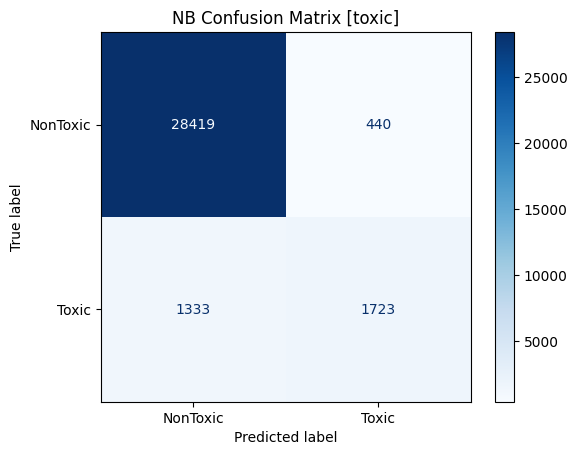

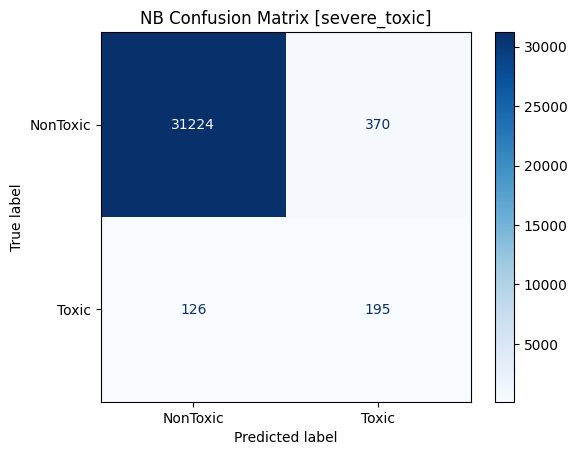

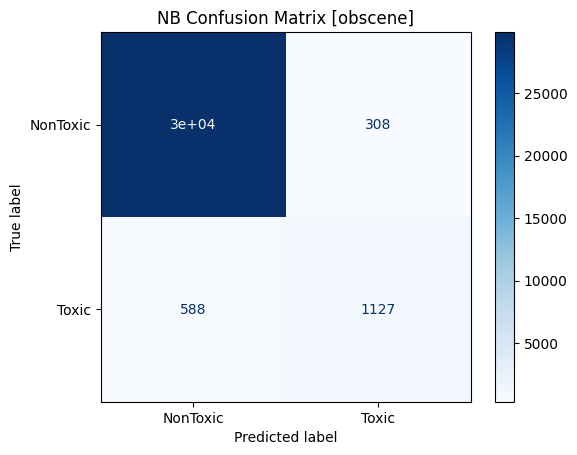

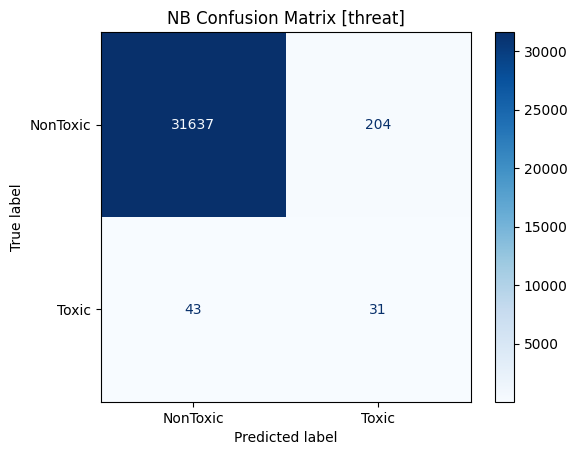

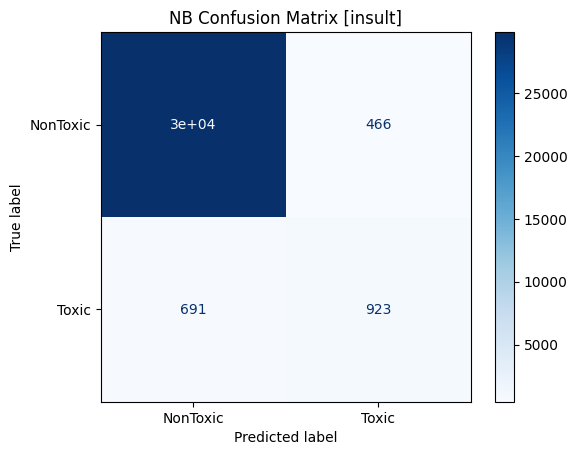

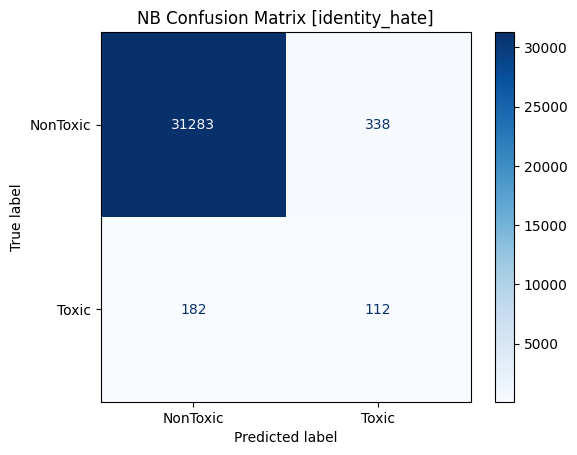

In [88]:
# Predict probabilities for each label
NB_predictions = {}

NB_accuracies = {}
NB_precisions = {}
NB_recalls = {}

for label, NB_model in NB_models.items():
  NB_predictions[label] = NB_model.predict(X_test_multi)

  NB_accuracies[label] = accuracy_score(y_test_df[label], NB_predictions[label])
  NB_precisions[label] = precision_score(y_test_df[label], NB_predictions[label])
  NB_recalls[label] = recall_score(y_test_df[label], NB_predictions[label])

  print("Metrics for " + label + ":")
  print("Accuracy:", NB_accuracy)
  print("Precision:", NB_precision)
  print("Recall:", NB_recall)
  print('\n')

  # Build our confusion matrix
  NB_cm = confusion_matrix(y_true=y_test_df[label], y_pred=NB_predictions[label])
  disp = ConfusionMatrixDisplay(confusion_matrix=NB_cm, display_labels=["NonToxic", "Toxic"])
  disp.plot(cmap=plt.cm.Blues)
  disp.ax_.set_title("NB Confusion Matrix [" + label + "]")

In [89]:
# Overall performance of my multiclassification approach
overall_accuracy = sum(NB_accuracies.values())/len(NB_accuracies)
overall_precision = sum(NB_precisions.values())/len(NB_precisions)
overall_recall = sum(NB_recalls.values())/len(NB_recalls)

print("Overall Performance:")
print("-----------------------------")
print("Accuracy:", overall_accuracy)
print("Precision:", overall_precision)
print("Recall:", overall_recall)

Overall Performance:
-----------------------------
Accuracy: 0.9734241996971119
Precision: 0.495398007447527
Recall: 0.5333618034474908


# Deep Learning Using Word Embeddings [Incomplete]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, toxic_labels, test_size=0.2, random_state=42)

In [ ]:
TOKEN_LIMIT = 100000
# Initialize the TextVecotization layer (this layer includes tokenization), which keeps the 1000 most frequent words
# "Adapt" the TextVectorization layer to the input features, to build a vocabulary and convert the words to their respective integer indices
vectorizer = TextVectorization(max_tokens=TOKEN_LIMIT) # Shape (159571, 1000)
vectorizer.adapt(X_train)

# Convert the features into a sequence of integers using the TextVectorization layer
# Any words not within the 1000 most frequent words will be ignored and not have an integer index assigned to it
vectorized_sequences = vectorizer(X_train)
mapped_vocabulary = vectorizer.get_vocabulary()

In [ ]:
# Serialize my vectorized sequences
with open(base_path+"/Serializations/vectorized_sequences", "wb") as fp: pickle.dump(vectorized_sequences, fp)

In [ ]:
# Read (load) in my vectorized sequences
vectorized_sequences = pickle.load(open(base_path+"/Serializations/vectorized_sequences", "rb"))

In [ ]:
print(features[2]) # Original String
print(vectorized_sequences[2]) # Vectorized (i.e. Tokenized) String
print(vectorized_sequences.shape) # Vectorized Features Shape

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
tf.Tensor([425 441  70 ...   0   0   0], shape=(1403,), dtype=int64)
(159571, 1403)


In [ ]:
DL_model = Sequential()
DL_model.add(Embedding(input_dim=TOKEN_LIMIT + 1, output_dim=32))
DL_model.add(Bidirectional(LSTM(32, activation='tanh')))
DL_model.add(Dense(100, activation="relu"))
DL_model.add(Dense(100, activation="relu"))
DL_model.add(Dense(1, activation="sigmoid"))

DL_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", "Precision", "Recall"])
DL_model.summary()

DL_model.fit(X_train, y=y_train, epochs=1, batch_size=32)

In [ ]:
# Serialize (pickle) my DL_model
with open(base_path+"/Serializations/DL_model", "wb") as fp: pickle.dump(DL_model, fp)

In [ ]:
# Read (load) in my DL_model
DL_model = pickle.load(open(base_path+"/Serializations/DL_model", "rb"))

DL_pred = encode_binary(DL_model.predict(X_test))
DL_CM = confusion_matrix(y_true=y_test, y_pred=DL_pred)

# Build our confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=DL_CM, display_labels=["NonToxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("DL Confusion Matrix")

# Comment Toxicity Detection Model Writeup

## Abstract

Comment sections can sometimes get out of hand through unsolicited vulgar and toxic comments. As such, trying to monitor all these comments in a comment section, let alone multiple comment sections, can prove to be a difficult, if not impossible, task. The goal of this project is to create a tool, using supervised learning, that would be capable of identifying toxic and unwarranted comments for the purposes of further improving the overall safety and quality of a given platform. Three machine learning models consisting of: Logistic Regression, Naive Bayes, and a Neural Network were used to categorize these comments as either "Toxic" or "NonToxic" and were then further categorized using Naive Bayes and a multi-classification approach of "One Vs. Rest." Despite the many challenges encountered during hyperparameter tuning, particularly with respect to optimizing model performance, the proposed approach demonstrates promise in automating comment moderation, but further refinement and optimization of hyperparameters are warranted to improve the model.

## Introduction

Despite the vast majority of comments being found to either be neutral or positive, there are many times negative can find their way into a range of communication platforms. Knowing this, I tackled the problem of comment classification by taking a set of input features that consisted of a mixture of positive, neutral, and "toxic" (i.e. negative) comments and training three machine learning models on them. These three machine learning models – Logistic Regression, Naive Bayes, and a Neural Network – were trained to classify these comments as "Toxic" or "NonToxic" through binary classification. Additionally, a "One Vs. Rest" multi-classification approach was also employed to categorize these comments further by classifying them under a series of categories of "Toxicity" which consisted of the following categories: severely toxic, obscene, threat, insult, and identity hate.

## Related Work

Comment classification, and even comment toxicity classification, is not a new found challenge, but rather, it's been a problem that has been explored time and time again. This challenge in specific has been tackled through various means, with one of them being through Deep Learning techniques such as recurrent neural networks (RNN's), convolutional neural networks (CNN's) and transformer-based models like BERT. The performance between each models implementation ranged with accuracy scores as low as 50% to as high as over 90%. Two examples of a binary classification approach that show this range of performance include a CNN without embeddings(^1) and a Bert model with TensorFlow and Hugging Face's transformers as dependencies(^2). The former approach, demonstrated effective learning despite a class imbalance with an accuracy of 96%, but with a low precision score, mislabeling 44% of "Toxic" comments as "Not Toxic," and the latter approach demonstrating stronger performance, achieving a similar accuracy, but a higher precision in both positive and negative classification, with only 22% of toxic comments being mislabeled.

# Dataset

---

## Dataset Structure & Source

The dataset used consisted of eight columns labeled as: id, comment_text, severe_toxic, obscene, threat, insult, and identity hate. The first two columns were of type string, and the rest were of type boolean; The toxic column was an overarching column classifier that described a comment as either "toxic" or "nontoxic"; The remaining columns classify the comments by the type of toxicity inferred. So in other words the 'toxic' column indicates the presence of any type of toxicity, while the remaining columns specify the particular type. This dataset consists of approximately 160,000 features (comments) from the wikipedia comment section, and is 68.8 megabytes in size. This dataset was provided by "JigSaw" on Kaggle for a challenge that was hosted in December 2017 to address the very same problem that I tackled.

## Clearning & Preprocessing

The dataset was relatively clean, and only required minimal additional cleaning. The first column labeled as "id" was removed from the dataset, as it had no real usage. Preprocessing consisted of splitting the data into training and testing, transforming the X_train data into tokens or vectors which were then "fit" to the count vectorizer, and the X_test data was simply transformed into a set integers or tokens for later testing use. These tokens were then used to create a vocabulary, by identifying all the unique words in the entire corpus (collection of comments). This vocabulary is important for the "bag of words" representation, which in short is a collection of words, that disregards grammar and word order, and keeps track of the frequency of the words across the entire corpus. This "bag of words" allows for models such as Logistic Regression, Naive Bayes, and even a Sequential Neural Network to now be able to interpret text input and provide a predicted output.

<br>

In order to do all this, I first used a holdout technique where I dedicated 75% of my comments and binary outputs (features and targets/labels) to training the models, and 25% of it to testing it. Once I had my training and testing split up, I optimized my Count Vectorizer. This optimization included tuning the max features hyperparameter to a cap of features (i.e. maximum words) that varied by model and an ngram range that also varied by model. Additionally, it would be worth noting that ngrams, in short, are a sequence words, characters, or tokens, which are extracted from a text that capture its context by considering adjacent words or characters. This in turn, allows for a more nuanced analysis of the input, in comparison to a set of single independent words. Additionally, I ignored any "stop words" that fall under the common "english" category, such as articles, pronouns, prepositions, and other frequently occurring words that do not add much context to the overall meaning of the sentence.

# Logistic Regression

---



## Method

The objective of my project was to classify comments as either toxic or nontoxic, and logistic regression thrives at such tasks, being an optimal tool for binary classification. Logistic regression models the probability of one class directly using a logistic function, and the probability of the other class is implicitly represented as its opposite. After the training of a Logistic Regression model, it will output coefficient values in the range of zero to one, where the decision boundary, or separating hyperplane, can then be used to categorize a comment appropriately. In this specific case, if an output coefficient value falls below the decision boundary (closer to 0) then the comment is classified as "Toxic," if the output coefficient falls above decision boundary (closer to 1), then it's considered "NonToxic." In addition to providing interpretable results, it is good at handling outliers, and is quite efficient thanks to its computational simplicity, handling large datasets with relatively low memory requirements in comparison to something like a neural network.

## Mathematical Notation

> Logistic Function (Sigmoid Function)
\begin{align*}
\sigma(z) &= \frac{1}{1 + e^{-z}} \\
\end{align*}

## Experiments & Results

For my logistic regression model I implemented the default parameters as the baseline to which it achieved high accuracy over 90 percent, but was actually quite misleading because the overall recall indicated that it may actually be struggling with correctly categorizing comments, mislabeling false negatives, and false positives. Drawing out a confusion matrix only further cemented this belief providing only around 50% precision for negative classification. As such I attempted a variety of hyperparameter tuning to improve these results further. What I found was that by raising the maximum features used, and testing different ranges of ngrams was able to improve the overall precision of the negative classification. The rationale behind tuning the maximum features and ngrams was that by tuning the features I could broaden the overall vocabulary, capturing more informative features from the data, and tuning the ngrams would allow for a more nuance understanding of the context in the comments, and I found around 2000 features to provide relatively decent results, and raising the ngram range to (1,3) to be a bit of sweet spot for improving the overall understanding of context in the comments, whenever I tried raising this higher, I found that the overall precision actually worsened.

<br>

Here is a Confusion Matrix of the results:

[Optimized Logistic Regression Model Confusion Matrix](https://drive.google.com/file/d/1Br-CEqjCflN3WGJLOSy6lh-ivnB7zNZo/view?usp=sharing)

<br>

In this confusion matrix you can see that there are 35,651 true positives, 427 false positives, 1499 false negatives, and 2316 true negatives. Overall this confusion matrix indicates that these results were still not all that accurate, but they did show an improvement in the overall precision and recall, thanks to the improvement in precision of the negative classification. The overall precision of the negative classification (true negatives vs false negatives) increased by 10 percent, going form 50 to 60 percent. Overall, the positive classification, tended to be quite accurate throughout, with the results returning a precision accuracy of 99 percent.

# Naive Bayes (Multinomial Naive Bayes)

---



## Method

Similar to Logistic Regression, Naive Bayes is also an efficient and effective way of performing binary classification. On the other hand though Naive Bayes is a probabilistic classifier based on "Bayes' theorem." It works by assuming that all the features that it predicts on, are "independent" of each other. This means that it calculates the probability of each class and then picks the best one. For example, in this case, Naive Bayes can classify comment toxicity as "Toxic" or "NonToxic" based on the frequency of words in each class, calculating the probability that a label belongs to each class, and then selecting the class with the highest probability as the prediction.

## Mathematical Notation

### Bayes' Theorem

\begin{align*}
P(y \mid X) = \frac{P(X \mid y) \cdot P(y)}{P(X)}
\end{align*}


## Experiments & Results

For my Naive Bayes model I implemented the default parameters as the baseline to which it achieved very similar results to the Logistic Regression model, and so I once again drew out a confusion matrix to further review this and as expected, the positive classification resulted in high success, but the negative classification was quite poor. As such, I attempted to use the same hyperparameters as my Logistic Regression approach, and interestingly enough, I found that these parameters did not perform well on my Naive Bayes model, and actually gave a worse performance. What I found was that by lowering the maximum features to 1000, and decreasing ngrams to (1,1),  I was able to improve the overall precision of the negative classification, and conclude with similar results to my Logistic Regression Model.

<br>

Here are my Confusion Matricies of the results:

[NB Confusion Matrix Using Same Hyperparameters as LR](https://drive.google.com/file/d/1Ztp0lZLVyAlg3272jqhKwC0XQaz99B66/view?usp=drive_link)


[NB Confusion Matrix Using Different Hyperparameters](https://drive.google.com/file/d/1TSIdc89DHVgESGUwQwazEYjEBdah_YdK/view?usp=drive_link)

<br>

Similar to Logistic Regression model, improved the baseline performance of the model, but these results were still not very satisfactory, indicating a need for further optimization and refinement. Overall One important thing worth noting is that although the tuning for one model may yield significant improvements in performance, it does not necessarily mean that those same hyper parameters will yield equivalent improvements on another model, and can even hurt that models performance, with a precision score of 51 percent for the negative classification using the same hyperparameters as the logistic regression model and a 61 percent precision score, for the negative classification, of a new set of tuned hyperparameters for the Naive Bayes model.

# Naive Bayes Extended: Multi-classification

---



For the multiclassification approach using naive bayes, I used the same hyperparameters from my binary classification, and using a "One Vs. Rest" approach for my classification. In short, a one versus rest approach of classification simply means that I perform a binary classification for each individual category, and then I calculate the metrics from each category and see how it performs.

<br>

Here are my Confusion Matricies of the results:

[NB_CF_Toxic](https://drive.google.com/file/d/13NkEDF4q78pkCLFT_clHXu1x0ISpZb-N/view?usp=sharing)

[NB_CF_Severe_Toxic](https://drive.google.com/file/d/1gPlnUk9kGn8aJ3icYV6oT84VqEjEXxqg/view?usp=drive_link)

[NB_CF_Obscene](https://drive.google.com/file/d/1MvaqQ4Rm3sbMns7fGbIoNX3ff2hhK2R2/view?usp=drive_link)

[NB_CF_Threat](https://drive.google.com/file/d/16adTQfKSvcUVudF6fdhMj1wTSkodDcCf/view?usp=drive_link)

[NB_CF_Insult](https://drive.google.com/file/d/1eDW_kXhpJjUvwwu4pT_CCwM3KXDjq18h/view?usp=drive_link)

[NB_CF_Identity_Hate](https://drive.google.com/file/d/1bnyv8IZDt4JYDGU4bXwJkME3IvZWfr4T/view?usp=drive_link)

<br>

All and all, I found that the result from using "One Vs. Rest" actually gave a worse result for my multiclassification, than when I was simply using binary classification to check if a comment was toxic or non toxic. The reason behind why this result may have occurred could possibly be due to the overarching problem of class imbalance being only further exasperrated when treating each label independently, which is the problem of "class imbalance." In addition, to the possibility of possible issues with a loss of information from tackling each label independently.

# Neural Network

---



## Method

Unlike Logistic Regression and Naive Bayes, Neural Networks are more computationally complex, but are able to handle more diverse relationships within data, and make them just as suitable for comment toxicity classification. In short, a basic neural network is composed of layers of interconnected neurons, that each perform a weighted sum of inputs followed by an activation function. In the instance of my implementation, I used a "feedforward" neural network where I inputed data in one direction, and outputted it out the other. Similar to my other two models, I used a bag-of-words representation of my comments for my input layer, which consists of 100 neurons, with a ReLU (Rectified Linear Unit) activation function. My next two layers then consist of hidden layers with 256 and 100 neurons respectively. These layers apply a set of weights and biases to the input and pass the result through the ReLU activation function. Finally the final layer is an output layer of a single neuron with a sigmoid activation function. This sigmoid activation function will guaranteed that the output is a probability score between 0 and 1, which can then be used to predict the likelihood of a comment being "Toxic" or "NonToxic."

## Mathematical Notation

### Dense Layers




> First Dense Layer
\begin{align*}
&\text{Output} = \text{ReLU}(\text{Input} \times \text{Weights} + \text{Bias}) \\
\end{align*}

> Second Dense Layer
\begin{align*}
&\text{Output} = \text{ReLU}(\text{Input} \times \text{Weights} + \text{Bias}) \\
\end{align*}

> Third Dense Layer
\begin{align*}
&\text{Output} = \text{ReLU}(\text{Input} \times \text{Weights} + \text{Bias}) \\
\end{align*}

> Output Layer
\begin{align*}
&\text{Output} = \text{Sigmoid}(\text{Input} \times \text{Weights} + \text{Bias}) \\
\end{align*}

### ReLU (Rectified Linear Unit) Function
\begin{align*}
f(z) &= \max(0, z) \
\end{align*}

### Sigmoid Function
\begin{align*}
\sigma(z) &= \frac{1}{1 + e^{-z}} \\
\end{align*}

### Loss Function (Binary Crossentropy)
\begin{align*}
&\text{Loss} = -\frac{1}{N}\sum_{i=1}^{N}\left(y_i\log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)\right)
\end{align*}

### Text Accuracy
\begin{align*}
\frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
\end{align*}

### Precision
\begin{align*}
\frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\end{align*}

### Text Accuracy
\begin{align*}
\frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{align*}

## Experiments & Results

Contrary to expectations, the Neural Network approach, added more complexity to the overall problem, but did not yield significantly better results than the Logistic Regression and Naive Bayes models. The neural network involved far more hyperparamater tuning than the previous two models due its complexity, which seemed to not truly be worth the computational cost. I found that adding higher iterations with epochs of 10 or 20 did not yield any significant boost compared to using something along the lines of 3 epochs. Additionally, I found that having a shallow model with have one input layer, two hidden layers, and 1 output layer was the sweet spot for my classification. Whenever I attempted to add a dropout layer, I found that the negative classification would sometimes get skewed, and at times even degraded my final results. With that said, I did find that through tuning having a feature limit of 2000, and ngram range of (1,3) I yielded slightly better results than attempting to use the same hyperparameters as the Logistic Regression Model or even the Naive Bayes model.

<br>

Here is a Confusion Matrix of my Results: [Confusion Matrix of my Tuned Neural Network](https://drive.google.com/file/d/1aJmHC4lADuUxD5qRL9FhD3s7xpVXJYwY/view?usp=drive_link)

<br>


Similar to my other models, I found that these results were still not very fortuitous, indicating a need for further improvement. My final output consisted of an accuracy of 96 percent, a precision of 89 percent, and a recall of 72 percent, but many of these results being heavily skewed by the positive classifications, as shown in my confusion matrix with an uneven balance of data, and a high misclassification of "toxic" comments.

# Discussion and Future Work

---



The key findings of my project were that building a model that correctly classifies comments as either "toxic" or "nontoxic" requires a heavy amount of tuning, and would require further actions to be taken. These overall results also indicated that a complex model is not necessarily needed in order to correctly classify comments, with a Neural Network, and many other previous works, not really yielding significantly better results.

Overall, I learned how to perform multi classification by tokenizing my inputs using techniques such as count vectorization for the creation of a bag of words, giving me the opportunity to represent textual data in a format that machine learning models such as Logistic Regression, Naive Bayes, and a Neural Network are able to process. I learned of the importance of preprocessing steps such as stop-word removal, and feature tuning, and grew a further understanding of the implementation and usage of such models for tasks such as text classification in Natural Language Processing.

If I had more time and additional resources, I would go back, and redo my preprocessing. I would further clean up the data and analyze it for possible key indicators of toxicity, such as an excessive use of exclamation points, misspelling, and reviewing whether or not certain aspects of text are necessary for toxicity classification, such as numbers and or special characters. I would also look into using lemmatization, and implementing under-sampling. I would also look to retrying to use weights for my models, as I believe those could have yielded better results if implemented correctly.

I would also focus less on tuning three different models and once, and choose one model I could dedicate myself to improving for the goal of comment classification. Based on my results I would most likely stick with the Logistic Regression model and aim to try to fine tune it for comment toxicity classification.

Additionally, the resources provided by Google Colab were quite scarce, and so if I could I would have dedicated myself to working on my project from the idea lab or some computer better gpu performance, especially if I build a deep learning model. Which leads me on to the next topic. Next on my agenda for tasks I was hoping to tackle was implementing a deep learning model which used word embeddings to classify these comments as either toxic or non toxic. I would then have worked on it further in hopes of making it a multi classification model. I believe that the overall results from this model would have potential advantages due to the fact that it would have had a better understanding of the context in a given text. The one downside to using deep learning, would mostly be computational cost, but I believe that this could be something that can be overlooked when looking for accuracy over efficiency.

# Resources Referenced

"Activation Functions in Neural Networks" by Towards Data Science. [Link](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

"Confusion Matrix for Multi-Class Classification" by Analytics Vidhya. [Link](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/)

"CountVectorizer" by Scikit-learn. [Link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

"Converting Text Documents to Token Counts with CountVectorizer" by KDnuggets. [Link](https://www.kdnuggets.com/2022/10/converting-text-documents-token-counts-countvectorizer.html#:~:text=Initialize%20the%20CountVectorizer%20object%20with,names%20to%20the%20data%20frame.)

"Estimation of Neurons and Forward Propagation in Neural Net" by Analytics Vidhya. [Link](https://www.analyticsvidhya.com/blog/2021/04/estimation-of-neurons-and-forward-propagation-in-neural-net/)

"Exploring Feature Extraction Techniques for Natural Language Processing" by Eskandar Sahel. [Link](https://medium.com/@eskandar.sahel/exploring-feature-extraction-techniques-for-natural-language-processing-46052ee6514)

"Machine Learning: Multiclass Classification with Imbalanced Data Set" by Towards Data Science. [Link](https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a)

"Machine Learning: Word Embedding & Sentiment Classification using Keras" by Towards Data Science. [Link](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)

"Mathematical Formulation of Feed Forward Neural Network" by Turing. [Link](https://www.turing.com/kb/mathematical-formulation-of-feed-forward-neural-network)

"Multi-Class Metrics" by Evidently AI. [Link](https://www.evidentlyai.com/classification-metrics/multi-class-metrics#:~:text=To%20calculate%20the%20precision%2C%20divide,True%20Positives%20and%20False%20Negatives.)

"The Mathematics of Neural Network" by Coinmonks. [Link](https://medium.com/coinmonks/the-mathematics-of-neural-network-60a112dd3e05)

"Naïve Bayes Algorithm" by Analytics Vidhya. [Link](https://medium.com/analytics-vidhya/na%C3%AFve-bayes-algorithm-5bf31e9032a2)

"Performance Comparison of Multi-Class Classification Algorithms" by Gursev Pirge. [Link](https://gursev-pirge.medium.com/performance-comparison-of-multi-class-classification-algorithms-606e8ba4e0ee)

"Python Keras Text Classification" by Real Python. [Link](https://realpython.com/python-keras-text-classification/)

"TextVectorization Class" by Keras. [Link](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/#textvectorization-class)

"The Math Behind Logistic Regression" by Analytics Vidhya. [Link](https://medium.com/analytics-vidhya/the-math-behind-logistic-regression-c2f04ca27bca)

"Understanding Embedding Layer in Keras" by Medium. [Link](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce)

"What and Why Behind fit_transform() vs transform() in Scikit-learn" by Parul Pandey. [Link](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)

"What Are Tokens, Vectors, and Embeddings? How Do You Create Them?" by Sascha Metzger. [Link](https://medium.com/@saschametzger/what-are-tokens-vectors-and-embeddings-how-do-you-create-them-e2a3e698e037)

"What is Logistic Regression?" by Spiceworks. [Link](https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/)

"Word Embeddings" by Machine Learning Works. [Link](https://www.machinelearningworks.com/tutorials/bag-of-words#:~:text=Enumerating%20Word%20Counts&text=In%20simpler%20terms%2C%20a%20bag,there%20are%20five%20unique%20words.)

## Implementations Mentioned in Related Work

"Jigsaw Olid Bert Base Cased Unfreeze" by Yekun Wang. [Link](https://www.kaggle.com/code/yekunwang2/jigsaw-olid-bert-base-cased-unfreeze)

"WordCNNWithoutPretrainEmbed" by Dave Lo. [Link](https://www.kaggle.com/code/davelo12/wordcnnwithoutpretrainembed)